In [31]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("Electric_Production.csv")

In [3]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [4]:
df.dtypes

DATE           object
IPG2211A2N    float64
dtype: object

#### Rename the column to make more readable

In [5]:
df.rename(columns={'IPG2211A2N': 'electric_production'}, inplace=True)

In [6]:
df.isnull().sum()

DATE                   0
electric_production    0
dtype: int64

In [7]:
df.describe()

,electric_production
count,397.000000
mean,88.847218
std,15.387834
min,55.315100
25%,77.105200
50%,89.779500
75%,100.524400
max,129.404800


In [8]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [9]:
max_year = df['DATE'].dt.year.max()
min_year = df['DATE'].dt.year.min()

#### Graph the data to make sure whether the data is staionary or not

In [10]:
import matplotlib.pyplot as plt

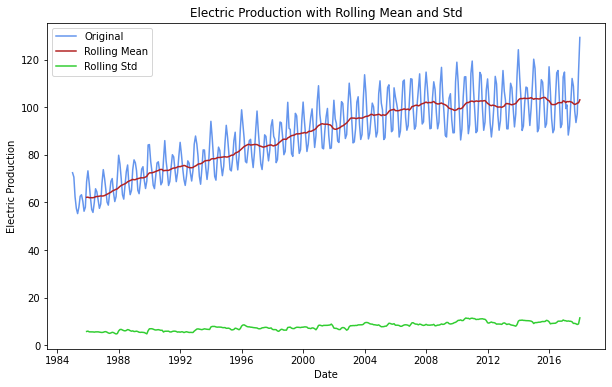

In [11]:
# Calculate rolling mean and std
rolling_mean = df['electric_production'].rolling(window=12).mean()
rolling_std = df['electric_production'].rolling(window=12).std()

plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['electric_production'], color='cornflowerblue', label='Original')
plt.plot(df['DATE'], rolling_mean, color='firebrick', label='Rolling Mean')
plt.plot(df['DATE'], rolling_std, color='limegreen', label='Rolling Std')
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Electric Production')  # Label for y-axis
plt.title('Electric Production with Rolling Mean and Std')
plt.legend()

<AxesSubplot: >

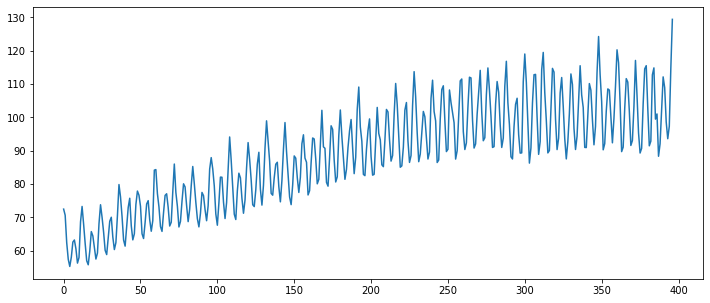

In [12]:
df['electric_production'].plot(figsize =(12,5))

#### Separating the test data and train data for training the ARIMA model

In [13]:
msk = (df.index < len(df)-120)
df_train = df[msk]['electric_production'].copy()
df_test = df[~msk]['electric_production'].copy()

#### Graph the PACF and ACF and check the P value to check if the data is stationary

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

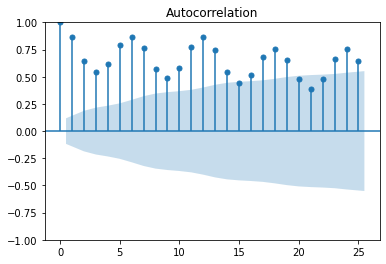

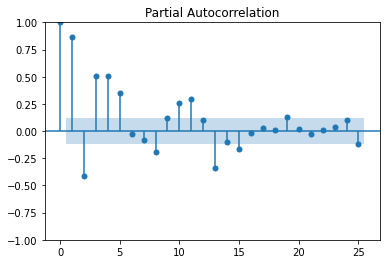

In [15]:
acf_original = plot_acf(df_train)
pacf_original = plot_pacf(df_train)

In [16]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df_train)
print(f'p-value : {adf_test[1]}')

p-value : 0.76652754634143


#### P value is greater than 0.05, so the data is not stationary

#### differentiate data N with data N-1 to get the stationary data

In [17]:
df_train_diff = df_train.diff().dropna()
df_train_diff

1      -1.8332
2      -8.2218
3      -4.9788
4      -2.1563
5       2.7753
        ...   
272   -12.5720
273    -8.5248
274     0.9058
275    12.8402
276     8.0803
Name: electric_production, Length: 276, dtype: float64

<AxesSubplot: >

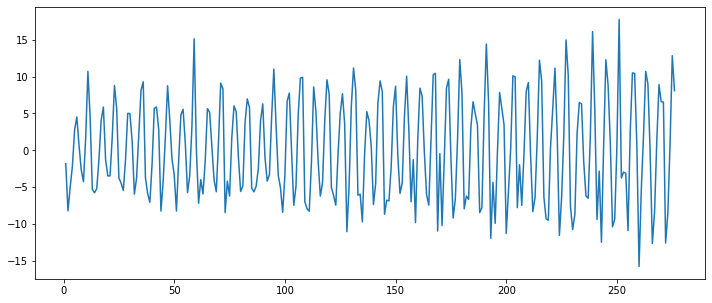

In [18]:
df_train_diff.plot(figsize =(12,5))

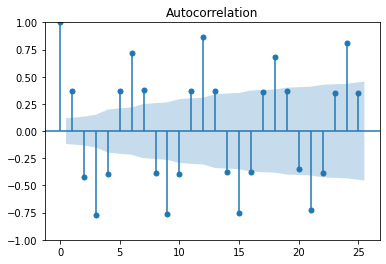

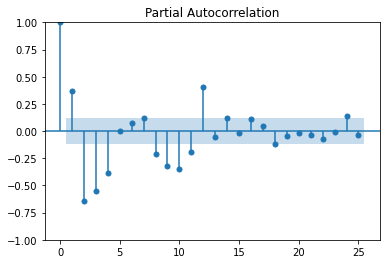

In [19]:
acf_original = plot_acf(df_train_diff)
pacf_original = plot_pacf(df_train_diff)

In [20]:
adf_test = adfuller(df_train_diff)
print(f'p-value : {adf_test[1]}')

p-value : 1.5409359664633932e-08


#### The P value is below 0.05, the data has become stationary

#### Use auto-arima to get the best combination of P, D, and Q

In [21]:
from pmdarima import auto_arima

In [22]:
stepwise_fit = auto_arima(df['electric_production'], trace = True,
                         suppress_warnings = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2750.050, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.759, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2624.463, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2748.185, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2625.508, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2525.516, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2493.118, Time=0.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2449.570, Time=0.30 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2449.577, Time=0.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2431.710, Time=0.49 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=2431.461, Time=0.31 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2359.635, Time=0.49 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
len(df_test)

120

#### Train and test the data with the  ARIMA (2,1,4) model

In [25]:
model = ARIMA(df_train, order = (2,1,4))
model = model.fit()

In [26]:
start = len(df_train)
end = len(df_train) + len(df_test) - 1
predictions = model.predict(start=start, end=end, typ='levels')

C:\Users\russe\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [27]:
predictions

277    112.267100
278    102.105471
279     92.994471
280     93.864151
281    103.839870
          ...    
392    102.220779
393     93.331160
394     94.085547
395    103.724725
396    112.608579
Name: predicted_mean, Length: 120, dtype: float64

In [28]:
actual_values = df_test

In [29]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(actual_values, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

Mean Absolute Error (MAE): 3.610057928542358


In [32]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(actual_values, predictions)
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Mean Absolute Percentage Error (MAPE): 3.5106412840045556%


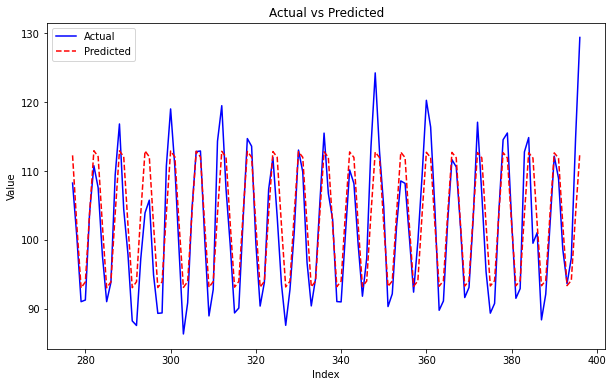

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(actual_values.index, actual_values, label='Actual', color='blue')
plt.plot(actual_values.index, predictions, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()